Чтобы добавить датасет в ноутбук внутри Kaggle, нажмите в правой панели на кнопку Add data, в появившемся окне нажмите Search by URL, добавьте адрес датасета и выберите его: https://www.kaggle.com/abhigupta4981/coco2017

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

sample_submission = pd.read_csv('../input/mds-misis-dl-person-segmentation/sample-submission.csv')
image_paths_list = '/kaggle/input/coco2017/val2017/' + sample_submission.ImageId
image_paths_list

0       /kaggle/input/coco2017/val2017/val2017/0000005...
1       /kaggle/input/coco2017/val2017/val2017/0000004...
2       /kaggle/input/coco2017/val2017/val2017/0000003...
3       /kaggle/input/coco2017/val2017/val2017/0000003...
4       /kaggle/input/coco2017/val2017/val2017/0000003...
                              ...                        
2688    /kaggle/input/coco2017/val2017/val2017/0000002...
2689    /kaggle/input/coco2017/val2017/val2017/0000000...
2690    /kaggle/input/coco2017/val2017/val2017/0000004...
2691    /kaggle/input/coco2017/val2017/val2017/0000000...
2692    /kaggle/input/coco2017/val2017/val2017/0000004...
Name: ImageId, Length: 2693, dtype: object

In [2]:
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms.presets.segmentation import test_transform
import gluoncv
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg
# using cpu
ctx = mx.gpu(0)

In [3]:
#другие модели можно найти с помощью gluoncv.model_zoo.get_model_list()
models = {
#     'fcn_resnet101_coco': {'prediction_codes': 'pascal_voc'},
#     'fcn_resnet101_voc': {'prediction_codes': 'pascal_voc'},
#     'fcn_resnet101_ade': {'prediction_codes': 'ade20k'},
    
#     'psp_resnet101_coco': {'prediction_codes': 'pascal_voc'},
#     'psp_resnet101_voc': {'prediction_codes': 'pascal_voc'},
#     'psp_resnet101_ade': {'prediction_codes': 'ade20k'},
    
#     'deeplab_resnet101_coco': {'prediction_codes': 'pascal_voc'},
#     'deeplab_resnet101_voc': {'prediction_codes': 'pascal_voc'},
#     'deeplab_resnet101_ade': {'prediction_codes': 'ade20k'},
    
    'deeplab_resnet152_coco': {'prediction_codes': 'pascal_voc'},
    'deeplab_resnet152_voc': {'prediction_codes': 'pascal_voc'},
    'deeplab_resnest269_ade': {'prediction_codes': 'pascal_voc'},
}

for model_name, model_info in models.items():
    model_info['model'] = gluoncv.model_zoo.get_model(model_name, pretrained=True, ctx=ctx)

person_indices = {
    'pascal_voc': 15,
    'ade20k': 12
}

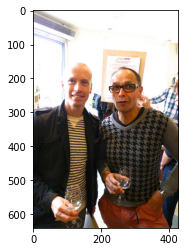

deeplab_resnet152_coco


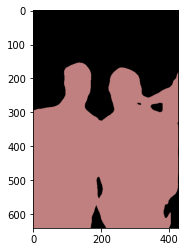

deeplab_resnet152_voc


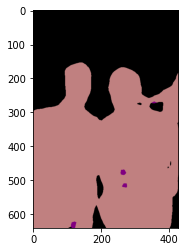

deeplab_resnest269_ade


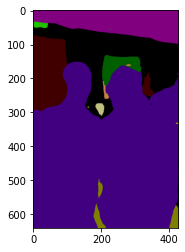

In [4]:
def get_all_predictions(img_orig, model_name):
    img = mx.nd.array(img_orig)
    img = test_transform(img, ctx)
    model_info = models[model_name]
    output = model_info['model'].predict(img)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
    predict = get_color_pallete(predict, model_info['prediction_codes'])
    return predict

image = np.array(Image.open(image_paths_list[91]))
plt.imshow(image)
plt.show()
for model_name, model_info in models.items():
    print(model_name)
    predict = get_all_predictions(image, model_name)
    plt.imshow(predict)
    plt.show()

854


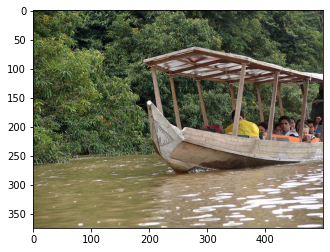

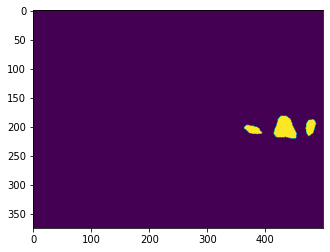

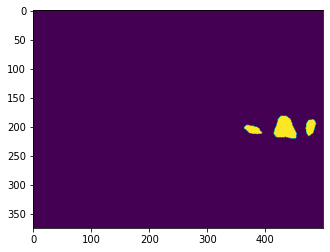

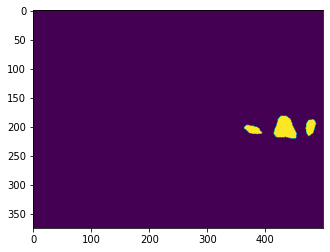

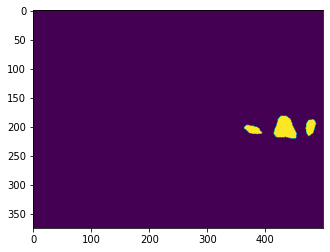

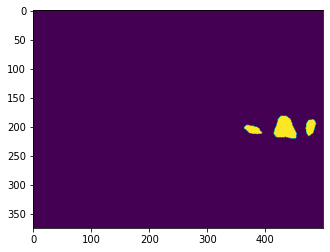

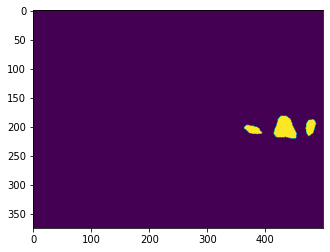

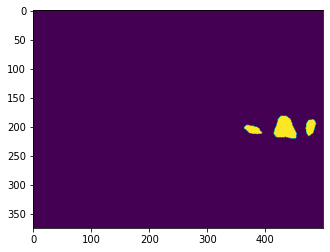

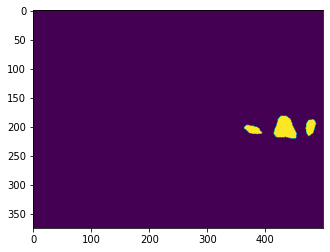

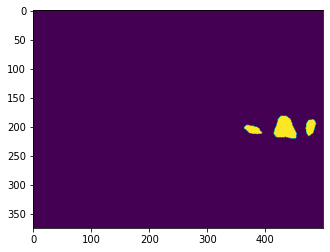

In [5]:
from random import randrange
def get_mask(img_orig, threshold = None):
    img = mx.nd.array(img_orig)
    img = test_transform(img, ctx)
    masks = []
    for model_name, model_info in models.items():
        model = model_info['model']
        person_idx = person_indices[model_info['prediction_codes']]
        output = model.predict(img)
        predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
        predict = (predict == person_idx).astype(int)
        masks.append(predict)
    mask = np.mean(np.array(masks), axis = 0)
    if threshold is not None:
        mask = np.where(mask > threshold, 1, 0)
    return mask

random_image = randrange(1, 1000)
print(random_image)

image = np.array(Image.open(image_paths_list[random_image]))
plt.imshow(image)
plt.show()

for threshold in np.linspace(0.2, 1, 9):
    mask = get_mask(image)
    plt.imshow(mask)
    plt.show()

# mask = get_mask(image, threshold = 0.8)
# plt.imshow(mask)
# plt.show()

In [6]:
predictions = []
from tqdm.notebook import tqdm
for path in tqdm(image_paths_list):
    image = np.array(Image.open(path).convert('RGB')) #есть ч-б изображения
    predictions.append(get_mask(image, threshold = 0.5))

  0%|          | 0/2693 [00:00<?, ?it/s]

In [7]:
# кодирование маски в EncodedPixels
def mask_to_rle(mask):
    mask_flat = mask.flatten('F')
    flag = 0
    rle_list = list()
    for i in range(mask_flat.shape[0]):
        if flag == 0:
            if mask_flat[i] == 1:
                flag = 1
                starts = i+1
                rle_list.append(starts)
        else:
            if mask_flat[i] == 0:
                flag = 0
                ends = i
                rle_list.append(ends-starts+1)
    if flag == 1:
        ends = mask_flat.shape[0]
        rle_list.append(ends-starts+1)
    #sanity check
    if len(rle_list) % 2 != 0:
        print('NG')
    if len(rle_list) == 0:
        rle = np.nan
    else:
        rle = ' '.join(map(str,rle_list))
    return rle

predictions_encoded = [mask_to_rle(mask) for mask in tqdm(predictions)]
sample_submission['EncodedPixels'] = predictions_encoded
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

  0%|          | 0/2693 [00:00<?, ?it/s]

,ImageId,EncodedPixels
0,val2017/000000532481.jpg,116925 3 117350 7 117776 8 118202 10 118628 11...
1,val2017/000000458755.jpg,47185 3 47662 6 48140 9 48594 3 48619 10 49070...
2,val2017/000000385029.jpg,401 1 405 76 880 2 884 77 1360 2 1364 77 1840 ...
3,val2017/000000311303.jpg,28190 5 28610 22 29037 26 29464 28 29891 29 30...
4,val2017/000000393226.jpg,44965 10 45442 13 45919 17 46397 19 46874 23 4...
